In [1]:
import pandas as pd
import numpy as np
import random
import lightgbm as lgb

# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [2]:
random.seed(123)

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [3]:
#df_train = pd.read_csv("/home/aleb/dmeyf2022/datasets/competencia1_2022.csv")

df_train = pd.read_csv("C:/Users/PC/Documents/DMEyF/datasets/competencia2_2022.csv")

Xtrain = df_train[df_train["foto_mes"] == 202101]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xcontinuan = df_train.query("foto_mes == 202101 and clase_ternaria == 'CONTINUA'")
Xcontinuan = Xcontinuan.drop("clase_ternaria", axis=1)

In [5]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

In [6]:
Xbajas.shape

(1514, 155)

Y nos deshacemos del target y limpiamos un poco la memoria.

In [7]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

In [8]:
Xtrain.shape

(161342, 154)

Hacemos un modelo **LGBM**

In [9]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Y miramos su importancia de variables

In [10]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
5,cliente_edad,141
107,ctrx_quarter,126
8,mrentabilidad_annual,119
10,mactivos_margen,103
22,mcuentas_saldo,91
...,...,...
76,cforex_buy,0
75,cforex,0
70,mtarjeta_master_descuentos,0
69,ctarjeta_master_descuentos,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [11]:
import shap

In [12]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [13]:
shap_values[0]

array([[-0.00490419,  0.        ,  0.        , ..., -0.01529934,
         0.        , -0.05303794],
       [-0.01396955,  0.        ,  0.        , ..., -0.00372101,
         0.        , -0.06072516],
       [-0.022926  ,  0.        ,  0.        , ..., -0.00712049,
         0.        ,  0.01607875],
       ...,
       [ 0.01525908,  0.        ,  0.        , ..., -0.00069827,
         0.        , -0.12853166],
       [ 0.00585244,  0.        ,  0.        , ..., -0.00020201,
         0.        , -0.06968133],
       [ 0.01802769,  0.        ,  0.        , ...,  0.00929811,
         0.        , -0.07368033]])

In [14]:
shap_values[1]

array([[ 0.00490419,  0.        ,  0.        , ...,  0.01529934,
         0.        ,  0.05303794],
       [ 0.01396955,  0.        ,  0.        , ...,  0.00372101,
         0.        ,  0.06072516],
       [ 0.022926  ,  0.        ,  0.        , ...,  0.00712049,
         0.        , -0.01607875],
       ...,
       [-0.01525908,  0.        ,  0.        , ...,  0.00069827,
         0.        ,  0.12853166],
       [-0.00585244,  0.        ,  0.        , ...,  0.00020201,
         0.        ,  0.06968133],
       [-0.01802769,  0.        ,  0.        , ..., -0.00929811,
         0.        ,  0.07368033]])

Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [15]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.004904,0.0,0.0,0.0,-0.002334,0.043758,0.013983,-0.041278,0.196130,0.000189,...,0.0,-0.000616,0.011454,-0.014267,-0.002817,-0.021265,0.0,-0.015299,0.0,-0.053038
1,-0.013970,0.0,0.0,0.0,-0.004382,0.048569,0.011794,0.006623,-0.096754,-0.011399,...,0.0,0.001421,-0.057956,-0.006672,0.011768,0.004617,0.0,-0.003721,0.0,-0.060725
2,-0.022926,0.0,0.0,0.0,-0.001292,-0.410950,0.011234,0.023368,0.058636,0.006585,...,0.0,0.001724,-0.030290,0.008067,-0.001562,-0.001833,0.0,-0.007120,0.0,0.016079
3,-0.018709,0.0,0.0,0.0,-0.002978,-0.213675,0.009803,-0.010034,-0.031874,-0.016405,...,0.0,0.001045,-0.000576,-0.014958,-0.003360,-0.063228,0.0,-0.000538,0.0,-0.111314
4,-0.012726,0.0,0.0,0.0,-0.002094,-0.203420,0.014232,-0.044485,0.168928,-0.012609,...,0.0,-0.002317,0.011874,-0.029288,-0.002845,-0.056215,0.0,-0.005447,0.0,-0.099260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.022436,0.0,0.0,0.0,-0.001274,0.045961,-0.071549,0.013633,-0.094009,-0.014529,...,0.0,0.001330,0.001324,-0.026429,-0.002340,0.062294,0.0,0.005572,0.0,0.079506
1510,0.014711,0.0,0.0,0.0,-0.002212,0.031978,-0.073241,0.003024,-0.105791,0.000905,...,0.0,0.001267,0.000154,-0.013291,0.011133,0.055093,0.0,0.003651,0.0,-0.071855
1511,0.015259,0.0,0.0,0.0,-0.002597,0.053010,-0.078954,0.022112,-0.120325,-0.005999,...,0.0,0.001442,0.000127,-0.011322,0.013452,0.080696,0.0,-0.000698,0.0,-0.128532
1512,0.005852,0.0,0.0,0.0,-0.003329,-0.179921,-0.070015,-0.004753,-0.104875,-0.015815,...,0.0,0.001135,-0.000063,-0.009317,0.012196,0.086014,0.0,-0.000202,0.0,-0.069681


Y consolidamos sus importancias

In [16]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter             0.966983
cpayroll_trx             0.611897
mtarjeta_visa_consumo    0.195651
mcuentas_saldo           0.170158
mpasivos_margen          0.141330
                           ...   
cpayroll2_trx            0.000000
ccajas_otras             0.000000
cpagodeservicios         0.000000
mpagodeservicios         0.000000
cforex_buy               0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior. El largo de la barra nos dice que tanta influencia la variable tiene en la predicción. Se ve como cada variable esta dividida equitativamente en dos clases, lo cual tiene sentido dado que la contribución a cada clase es la misma (pero negativa o positiva)

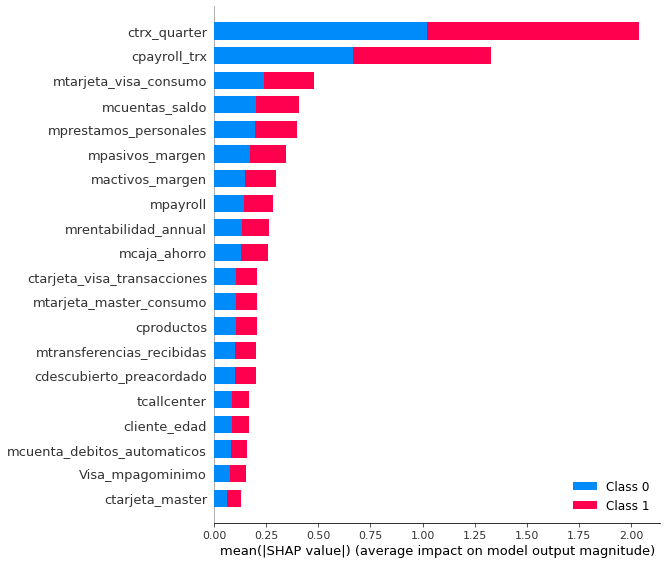

In [17]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

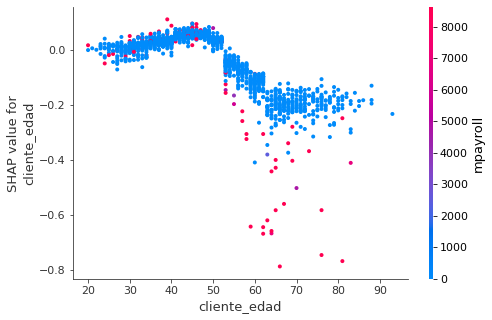

In [18]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [19]:
from umap import UMAP
import matplotlib.pyplot as plt


In [20]:
#Esto no funciona porque Xbajas contiene NaN

#embedding_2d = UMAP(
#  n_components=2, n_neighbors=40
#).fit_transform(Xbajas)
#plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [21]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])


In [22]:
embedding_2d

array([[ 4.0485926,  6.13024  ],
       [13.188841 ,  4.630367 ],
       [-0.9985995,  3.819076 ],
       ...,
       [ 6.8596196,  8.111596 ],
       [ 7.5982194, 12.438964 ],
       [-1.4168824,  2.884129 ]], dtype=float32)

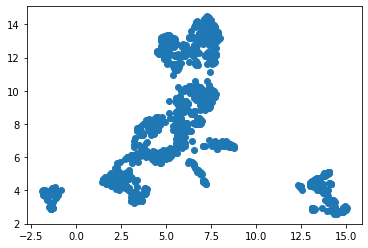

In [23]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

Explainers para Los clientes que continuan

In [24]:
explainer = shap.TreeExplainer(gbm)
shap_values_continuan = explainer.shap_values(Xcontinuan)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [25]:
shap_continuan = pd.DataFrame(shap_values_continuan[0], columns = Xcontinuan.columns)
shap_continuan

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.059399,0.0,0.0,0.0,-0.000296,-0.226096,0.036975,0.011353,0.106937,0.008824,...,0.0,0.006159,-0.020858,-0.002582,-0.001113,-0.013512,0.0,-0.011341,0.0,0.008347
1,-0.030114,0.0,0.0,0.0,-0.004172,0.049834,0.020299,0.007580,0.025602,-0.018599,...,0.0,0.000615,-0.003269,-0.015208,0.003362,-0.020631,0.0,0.008871,0.0,-0.037425
2,-0.015525,0.0,0.0,0.0,-0.000431,-0.131010,-0.022083,0.026972,-0.228822,0.045084,...,0.0,0.001382,0.011327,0.014814,-0.002103,0.003128,0.0,-0.011976,0.0,0.111797
3,-0.016679,0.0,0.0,0.0,-0.000467,0.110202,0.033312,0.008397,0.074011,0.000968,...,0.0,0.000055,-0.002720,-0.039359,0.019646,0.016658,0.0,0.001402,0.0,0.008726
4,-0.024563,0.0,0.0,0.0,-0.001399,0.076367,0.020729,-0.038523,0.264719,-0.011762,...,0.0,0.007090,-0.000239,-0.049873,-0.001791,-0.023731,0.0,-0.014604,0.0,0.138070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159823,0.014883,0.0,0.0,0.0,-0.002832,0.021506,-0.072522,0.016694,-0.115339,-0.001116,...,0.0,0.001442,0.000127,-0.007158,0.014346,0.072067,0.0,0.002196,0.0,-0.110212
159824,0.020811,0.0,0.0,0.0,-0.002118,0.007973,-0.076953,0.020665,-0.092561,0.000034,...,0.0,0.001603,0.000463,-0.008493,0.012611,0.074352,0.0,0.001722,0.0,-0.107181
159825,0.010423,0.0,0.0,0.0,-0.002472,0.022727,-0.129579,0.020816,-0.052835,-0.002553,...,0.0,0.001300,-0.001313,-0.001045,0.007308,0.029410,0.0,0.008675,0.0,-0.065754
159826,0.023692,0.0,0.0,0.0,-0.002471,0.016649,-0.096654,0.025140,-0.058194,-0.004564,...,0.0,0.001603,-0.006735,0.014977,0.008149,0.038802,0.0,0.011276,0.0,-0.069147


In [26]:
shap_importancias_continuan = shap_continuan.mean().abs().sort_values(ascending=False)
shap_importancias_continuan

cpayroll_trx                   0.028909
ccomisiones_mantenimiento      0.022648
mcaja_ahorro                   0.021373
cliente_edad                   0.019379
mcuentas_saldo                 0.012955
                                 ...   
ccajeros_propios_descuentos    0.000000
mcajeros_propios_descuentos    0.000000
ctarjeta_visa_descuentos       0.000000
mtarjeta_visa_descuentos       0.000000
cforex_buy                     0.000000
Length: 154, dtype: float64

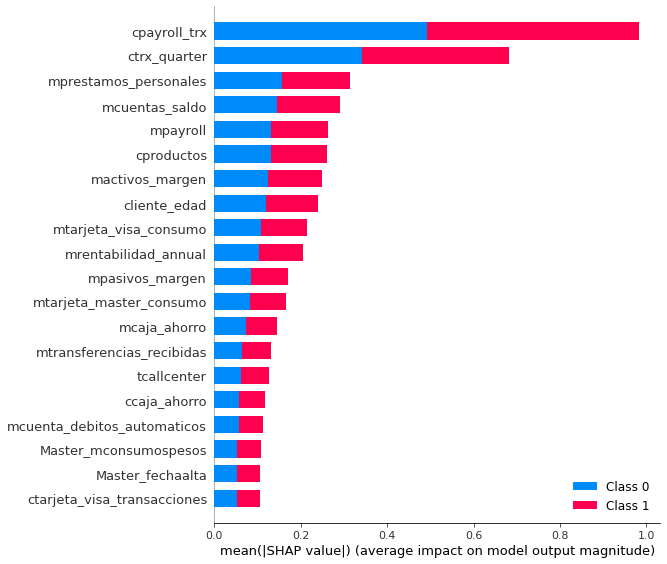

In [27]:
shap.summary_plot(shap_values_continuan, Xcontinuan)


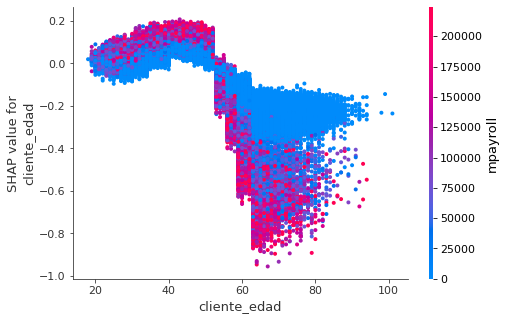

In [28]:
shap.dependence_plot("cliente_edad", shap_values_continuan[0], Xcontinuan)